In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from scipy.io import loadmat
import numpy as np
import os
from tensorflow import keras
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# load data from matlab
data = loadmat('/content/gdrive/MyDrive/keypoint/LSTM_training.mat')
labels = loadmat('/content/gdrive/MyDrive/keypoint/labels.mat')

## dataframe

In [ ]:
df = pd.DataFrame(columns=['flip', 'frame', 'joint','x','y','fps','time','label'])
df

In [ ]:
for i in range(4438):
    line = data['DLC_sequences'][i][0]
    total_frame = line.shape[1]
    fps = total_frame/3
    label = labels['ans'][i][0]
    # print(line[0].shape)
    side = 'left' if i < 2219 else 'right'
    part = ['hip','ankle','feet']
    for j in range(total_frame):
        #print(row)
        row = pd.DataFrame([{'flip':i, 'frame':j, 'joint': side+'-hip','x':line[0][j],'y':line[1][j],'fps':fps,'time':3.0*j/total_frame,'label':label},
                           {'flip':i, 'frame':j, 'joint': side+'-ankle','x':line[2][j],'y':line[3][j],'fps':fps,'time':3.0*j/total_frame,'label':label},
                           {'flip':i, 'frame':j, 'joint': side+'-foot','x':line[4][j],'y':line[5][j],'fps':fps,'time':3.0*j/total_frame,'label':label}])
        df = pd.concat([df,row],ignore_index=True)


# Kinematics Features

In [ ]:
action_seq = data['kf_filtered_sequences']

In [ ]:
def get_angle_displacement(a):
    x = a['angle']
    y = a['angle_pre']
    return np.min(np.abs([y-x,y-x+360, y-x-360]))

In [ ]:
def build_features(rawx, T_max=90):
    t = rawx.shape[1]
    if t<T_max:
        # print(t, T_max)
        rawx = np.pad(rawx,((0,0),(0, T_max-rawx.shape[1])), mode = 'constant')

    df = pd.DataFrame(rawx.T, columns = ['x0','y0','x1','y1','x2','y2'])
    total_frame = rawx.shape[1]
    fps = total_frame/3.0  # 3s clip

    # compute angle
    dot = (df['x0']-df['x1'])*(df['x2']-df['x1'])+(df['y0']-df['y1'])*(df['y2']-df['y1'])
    det = (df['x0']-df['x1'])*(df['y2']-df['y1'])-(df['y0']-df['y1'])*(df['x2']-df['x1'])
    df['angle']=(np.arctan2(det,dot)*180/np.pi ).map(lambda x: x+360 if x<0 else x)

    # angle features
    df['angle_pre'] = df['angle'].shift()
    df['angle_pre'].iloc[0]= df['angle'].iloc[0]
    df['angle_displacement']=df.apply(get_angle_displacement,axis=1)
    df['angle_velocity'] = df['angle_displacement'] * fps

    # Calculate the differences between rows
    diff = df.diff()
    diff.iloc[0] = 0
    df['angle_acceleration'] = diff['angle_velocity'] * fps
    df['angle_acceleration_2'] = df['angle_acceleration']**2

    # xy features
    df['displacement_0'] = np.sqrt(diff['x0']**2 + diff['y0']**2)
    df['displacement_1'] = np.sqrt(diff['x1']**2 + diff['y1']**2)
    df['displacement_2'] = np.sqrt(diff['x2']**2 + diff['y2']**2)

    df['velocity_x0'] = diff['x0'] * fps
    df['velocity_x1'] = diff['x1'] * fps
    df['velocity_x2'] = diff['x2'] * fps

    df['velocity_y0'] = diff['y0'] * fps
    df['velocity_y1'] = diff['y1'] * fps
    df['velocity_y2'] = diff['y2'] * fps

    df['speed_0'] = df['displacement_0'] * fps
    df['speed_1'] = df['displacement_1'] * fps
    df['speed_2'] = df['displacement_2'] * fps

    #new diff
    diff = df.diff()

    diff.iloc[0] = 0
    df['acceleration_x0'] = diff['velocity_x0'] * fps
    df['acceleration_x1'] = diff['velocity_x1'] * fps
    df['acceleration_x2'] = diff['velocity_x2'] * fps

    df['acceleration_y0'] = diff['velocity_y0'] * fps
    df['acceleration_y1'] = diff['velocity_y1'] * fps
    df['acceleration_y2'] = diff['velocity_y2'] * fps

    df['acceleration_x0_2'] = df['acceleration_x0']**2
    df['acceleration_x1_2'] = df['acceleration_x1']**2
    df['acceleration_x2_2'] = df['acceleration_x2']**2

    df['acceleration_y0_2'] = df['acceleration_y0']**2
    df['acceleration_y1_2'] = df['acceleration_y1']**2
    df['acceleration_y2_2'] = df['acceleration_y2']**2

    return df.drop(columns=['angle_pre'])

# Seq2Seq Model

In [ ]:
# sequence class to load and vectorize batches of data
class Features(keras.utils.Sequence):
    def __init__(self, action_sequences,batch_size):
        self.action_sequences = action_sequences
        self.batch_size = batch_size


    def __len__(self):
        return math.ceil(len(self.action_sequences) / self.batch_size)


    def __getitem__(self, index):
        low = index * self.batch_size
        high = min(low + self.batch_size, len(self.action_sequences))
        batch_sequences = self.action_sequences[low:high]
        return np.array([
            build_features(sequence[0])
                for sequence in batch_sequences])

In [ ]:
tr = 200
val = 200
left_leg_end = 2219
batch_size = 20
all_tr = 1000

In [ ]:
# Instantiate data Sequences for each split
data_generator = Features(action_seq[:all_tr], batch_size)
valid_generator = Features(action_seq[all_tr:all_tr+val], batch_size)
test_generator = Features(action_seq[all_tr+val:left_leg_end], batch_size)

In [ ]:
all_label = labels['ans'].T[0]
left_leg_labels = all_label[:left_leg_end]

In [ ]:
loss_tracker = keras.metrics.Mean(name="loss")

class Seq2SeqModel(tf.keras.Model):
    # features: keypoint features of input sequences
    # fix_frame: the fixed legth of input sequences

    def __init__(self,features=35,timesteps=90,hidden_units=1024):
        super(Seq2SeqModel, self).__init__()
        self.hidden_units = hidden_units
        self.timesteps = timesteps
        self.features = features

        regularizer=tf.keras.regularizers.l2(0.01)
        # 3-layer Bi-GRU encoder
        self.encoder1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.hidden_units // 2, return_sequences=True,kernel_regularizer=regularizer))
        self.encoder2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.hidden_units // 2, return_sequences=True,kernel_regularizer=regularizer))
        self.encoder = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.hidden_units // 2, return_state=True))

        # 1 layer GRU decoder
        self.decoder =  tf.keras.layers.GRU(self.hidden_units, return_sequences=True)
        # prediction dense layer - regenerate only joints sequences
        self.pred_dense = tf.keras.layers.Dense(7, activation=None)

    def call(self, inputs):
        # inputs [batch_size, timesteps, features]
        x = self.encoder1(inputs)
        x = self.encoder2(x)
        encoder_outputs, forward_state, backward_state = self.encoder(x)
        final_state = tf.keras.layers.Concatenate(axis=-1)([forward_state, backward_state])
        decoder_outputs = self.decoder(tf.zeros_like(inputs), initial_state=final_state)
        regen_seq = self.pred_dense(decoder_outputs)

        return regen_seq, final_state

    def train_step(self, data):
        x = data
        orig = x[:,:,0:7]
        with tf.GradientTape() as tape:
            regen, enc = self(x, training=True)
            loss = keras.losses.mean_absolute_error(orig, regen)

        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        # update weights using the optimizer
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    def test_step(self, data):
        x = data
        orig = x[:,:,0:7]
        regen, enc = self(x, training=False)
        loss = keras.losses.mean_absolute_error(orig, regen)
        loss_tracker.update_state(loss)
        return {"loss": loss}

    @property
    def metrics(self):
        return [loss_tracker]

In [ ]:
model = Seq2SeqModel()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.95)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer)
model.build(input_shape=(None, 90,36))
model.summary()

Model: "seq2_seq_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  multiple                 1689600   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  multiple                 4724736   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  multiple                 4724736   
 nal)                                                            
                                                                 
 gru_3 (GRU)                 multiple                  3262464   
                                                                 
 dense (Dense)               multiple                  7175      
                                                    

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("/content/gdrive/MyDrive/motion_tracking", save_best_only=True)]
loss = []
knn_score = []

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/left_leg_model_1')

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=100,
    decay_rate=0.95)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer)
history = model.fit(data_generator, epochs=1, callbacks=callbacks, validation_data=valid_generator, verbose=1)

50/50 [==============================] - 29s 561ms/step - loss: 6.5562 - val_loss: 5.2076


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1,metric='cosine')
tr_feas = model.predict(data_generator)[1]
tr_label = left_leg_labels[:1000]
knn.fit(tr_feas,tr_label)
val_feas = model.predict(valid_generator)[1]
knn.score(val_feas,val_label)


10/10 [==============================] - 5s 473ms/step


In [ ]:
test_feas = model.predict(test_generator)[1]
test_label = left_leg_labels[all_tr+val:]
knn.score(test_feas,test_label)

51/51 [==============================] - 26s 505ms/step


0.44847890088321885

In [ ]:
val_label = left_leg_labels[all_tr:all_tr+val]

for i in range(5):
  tr_generator = Features(action_seq[i*tr:(i+1)*tr], batch_size) # 0-1000
  history = model.fit(tr_generator, epochs=10, callbacks=callbacks, validation_data=valid_generator, verbose=1)
  loss.append(history.history['loss'])
  knn = KNeighborsClassifier(n_neighbors=1,metric='cosine')
  tr_feas = model.predict(tr_generator)[1]
  tr_label = left_leg_labels[i*tr:(i+1)*tr]
  knn.fit(tr_feas,tr_label)
  val_feas = model.predict(valid_generator)[1]
  score = knn.score(val_feas,val_label)
  print(i*tr,"-",(i+1)*tr," KNN Score:",score)
  knn_score.append(score)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 138.3540

10/10 [==============================] - 45s 5s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 11s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 11s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 10s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 10s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 11s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 10s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10
10/10 [==============================] - 11s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
10/10 [==============================] - 10s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/10
10/10 [==============================] - 5s 4

KeyboardInterrupt: ignored

In [ ]:
model.load_weights("/content/gdrive/MyDrive/motion_tracking")

In [ ]:
print(knn_score)
print("Mean:", np.mean(knn_score))

[0.86, 0.84, 0.58, 0.62, 0.86, 0.82, 0.81, 0.45, 0.77, 0.83]
Mean: 0.744


In [ ]:
history.history

{'loss': [118.81346893310547,
  116.81387329101562,
  114.20560455322266,
  111.673828125,
  109.09930419921875,
  106.59659576416016,
  104.38026428222656,
  102.05962371826172,
  99.96363830566406,
  98.02566528320312],
 'val_loss': [145.77069091796875,
  143.08114624023438,
  140.2637481689453,
  137.36070251464844,
  134.5706024169922,
  131.9183349609375,
  129.2505340576172,
  126.86941528320312,
  124.5932388305664,
  122.4054183959961]}

In [ ]:
Loss_all = []
for i in loss:
  Loss_all = Loss_all+i

In [ ]:
Loss_all = np.array(Loss_all)

In [ ]:
Loss_all

array([790.50689697, 780.33538818, 770.04980469, 759.81567383,
       749.66967773, 739.62695312, 729.64813232, 719.75543213,
       709.84454346, 699.95465088, 690.11755371, 680.30639648,
       670.64593506, 661.02459717, 651.44891357, 641.94689941,
       632.46417236, 622.78717041, 613.32507324, 603.92474365,
       575.22460938, 566.56158447, 558.1439209 , 550.09082031,
       542.06445312, 534.14678955, 526.15948486, 518.41308594,
       510.71255493, 503.04226685, 495.34112549, 487.5960083 ,
       479.83117676, 472.25601196, 464.74517822, 457.13598633,
       449.68264771, 442.29779053, 434.96166992, 427.63388062,
       386.05270386, 378.80743408, 371.51895142, 364.40261841,
       357.3609314 , 350.37283325, 343.4559021 , 336.60025024,
       329.82299805, 323.05767822, 316.28231812, 309.5539856 ,
       302.94326782, 296.38754272, 289.8604126 , 283.38238525,
       276.96865845, 270.56814575, 264.2069397 , 257.93643188,
       269.52468872, 262.84225464, 256.08114624, 249.29

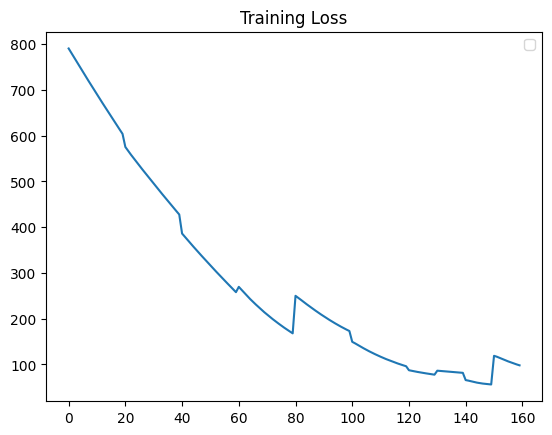

In [ ]:
epochs = range(0,Loss_all.shape[0])

plt.plot(epochs, Loss_all)
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_generator)

59/59 [==============================] - 30s 514ms/step - loss: 149.3657


149.36569213867188

In [ ]:
seq,enc = model.predict(data_generator)

50/50 [==============================] - 25s 508ms/step


In [ ]:
model.save('/content/gdrive/MyDrive/left_leg_model_2')

In [ ]:
pred = model.predict(test_generator)

2/2 [==============================] - 0s 217ms/step


In [ ]:
pred[0][1][0]

array([ 661.6185 ,  957.0315 ,  733.05255, 1056.4495 ,  657.01135,
       1219.1558 ], dtype=float32)

In [ ]:
test_generator[0][1][0][:6]

array([ 714.65253276,  894.55835196,  809.52909451, 1090.92485616,
        732.5133205 , 1261.04425059])

In [ ]:
pred[0][3][0]- test_generator[0][3][0][:6]

array([-27.79014816,  33.94704104, -42.29952375, -54.35113902,
        12.07169868, -27.71265771])

# Auto-encoder AEC

In [ ]:
loss_tracker = keras.metrics.Mean(name="loss")
class AEC(tf.keras.Model):
  def __init__(self,hidden_units=1024):
    super(AEC, self).__init__()
    # encoder
    self.fc1 = tf.keras.layers.Dense(hidden_units//2, activation='tanh') # 512
    self.fc2 = tf.keras.layers.Dense(hidden_units//4, activation='tanh') # 256
    self.fea = tf.keras.layers.Dense(hidden_units//8, activation='tanh') # 128
    # decoder
    self.fc3 = tf.keras.layers.Dense(hidden_units//4, activation='tanh')
    self.fc4 = tf.keras.layers.Dense(hidden_units//2, activation='tanh')

    self.pred = tf.keras.layers.Dense(hidden_units, activation=None)

  def call(self,inputs):
    # inputs [batch_size, hidden_units]
    x = self.fc1(inputs)
    x = self.fc2(x)
    feature = self.fea(x)

    x = self.fc3(feature)
    x = self.fc4(x)
    y = self.pred(x)

    return y, feature
  def train_step(self, data):
    x = data
    with tf.GradientTape() as tape:
      y, enc = self(x, training=True)
      loss = keras.losses.mean_squared_error(x, y)

    # compute gradients
    gradients = tape.gradient(loss, self.trainable_variables)
    # update weights using the optimizer
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    loss_tracker.update_state(loss)
    return {"loss": loss_tracker.result()}

  def test_step(self, data):
    x = data
    y, enc = self(x, training=False)
    loss = keras.losses.mean_squared_error(x, y)
    loss_tracker.update_state(loss)
    return {"loss": loss}

  @property
  def metrics(self):
    return [loss_tracker]

In [ ]:
aec = AEC()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.95)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
aec.compile(optimizer=optimizer)
aec.build(input_shape=(None,1024))
aec.summary()

Model: "aec_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             multiple                  524800    
                                                                 
 dense_9 (Dense)             multiple                  131328    
                                                                 
 dense_10 (Dense)            multiple                  32896     
                                                                 
 dense_11 (Dense)            multiple                  33024     
                                                                 
 dense_12 (Dense)            multiple                  131584    
                                                                 
 dense_13 (Dense)            multiple                  525312    
                                                                 
Total params: 1,378,944
Trainable params: 1,378,944
Non-train

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("/content/gdrive/MyDrive/feature_autoencoder", save_best_only=True)]

In [ ]:
tr_feas = model.predict(data_generator)[1]
tr_label = left_leg_labels[:all_tr]

val_feas = model.predict(valid_generator)[1]
val_label = left_leg_labels[all_tr:all_tr+val]

for i in range(5):
  history = aec.fit(tr_feas,epochs=5, callbacks=callbacks, verbose=1,batch_size=100)
  _,low_feas = aec.predict(tr_feas)

  knn = KNeighborsClassifier(n_neighbors=1,metric='cosine')
  knn.fit(low_feas,tr_label)
  _,low_val_feas = aec.predict(val_feas)
  score = knn.score(low_val_feas,val_label)
  print("KNN Score",score)
  knn_score.append(score)

5/5 [==============================] - 2s 449ms/step
Epoch 1/5
 1/10 [==>...........................] - ETA: 0s - loss: 3.5372e-06

10/10 [==============================] - 0s 5ms/step - loss: 2.3542e-06
Epoch 2/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.4073e-06

10/10 [==============================] - 0s 4ms/step - loss: 9.4588e-07
Epoch 3/5
 1/10 [==>...........................] - ETA: 0s - loss: 6.0953e-07

10/10 [==============================] - 0s 4ms/step - loss: 4.4720e-07
Epoch 4/5
 1/10 [==>...........................] - ETA: 0s - loss: 2.8499e-07

10/10 [==============================] - 0s 4ms/step - loss: 2.6773e-07
Epoch 5/5
 1/10 [==>...........................] - ETA: 0s - loss: 2.1499e-07

4/4 [==============================] - 0s 3ms/step
KNN Score 0.8
Epoch 1/5
 9/10 [==========================>...] - ETA: 0s - loss: 1.8807e-07

10/10 [==============================] - 0s 7ms/step - loss: 1.8646e-07
Epoch 2/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.6859e-07

10/10 [==============================] - 0s 4ms/step - loss: 1.7865e-07
Epoch 3/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.6734e-07

10/10 [==============================] - 0s 4ms/step - loss: 1.7593e-07
Epoch 4/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.7988e-07

10/10 [==============================] - 0s 4ms/step - loss: 1.7616e-07
Epoch 5/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.7860e-07

4/4 [==============================] - 0s 3ms/step
KNN Score 0.8
Epoch 1/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.8218e-07

10/10 [==============================] - 0s 5ms/step - loss: 1.7571e-07
Epoch 2/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.8874e-07

10/10 [==============================] - 0s 5ms/step - loss: 1.7500e-07
Epoch 3/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.7989e-07

10/10 [==============================] - 0s 4ms/step - loss: 1.7604e-07
Epoch 4/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.8553e-07

10/10 [==============================] - 0s 4ms/step - loss: 1.7534e-07
Epoch 5/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.8460e-07

4/4 [==============================] - 0s 3ms/step
KNN Score 0.83
Epoch 1/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.6689e-07

10/10 [==============================] - 0s 5ms/step - loss: 1.7559e-07
Epoch 2/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.6216e-07

10/10 [==============================] - 0s 4ms/step - loss: 1.7587e-07
Epoch 3/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.9658e-07

10/10 [==============================] - 0s 4ms/step - loss: 1.7501e-07
Epoch 4/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.8225e-07

10/10 [==============================] - 0s 4ms/step - loss: 1.7571e-07
Epoch 5/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.6264e-07

4/4 [==============================] - 0s 3ms/step
KNN Score 0.8
Epoch 1/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.6104e-07

10/10 [==============================] - 0s 5ms/step - loss: 1.7481e-07
Epoch 2/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.6969e-07

10/10 [==============================] - 0s 5ms/step - loss: 1.7655e-07
Epoch 3/5
 1/10 [==>...........................] - ETA: 0s - loss: 2.1313e-07

10/10 [==============================] - 0s 4ms/step - loss: 1.7777e-07
Epoch 4/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.6577e-07

10/10 [==============================] - 0s 4ms/step - loss: 1.7557e-07
Epoch 5/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.9238e-07

4/4 [==============================] - 0s 3ms/step
KNN Score 0.81


In [ ]:
test_feas = model.predict(test_generator)[1]
_,low_test_feas = aec.predict(test_feas)
test_label = left_leg_labels[all_tr+val:]

37/37 [==============================] - 0s 2ms/step


In [ ]:
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/left_leg_model_1')

In [ ]:
tr_feas = new_model.predict(data_generator)[1]
test_feas = new_model.predict(test_generator)[1]

knn.fit(tr_feas,tr_label)
knn.score(test_feas,test_label)

59/59 [==============================] - 29s 496ms/step


0.4756201881950385

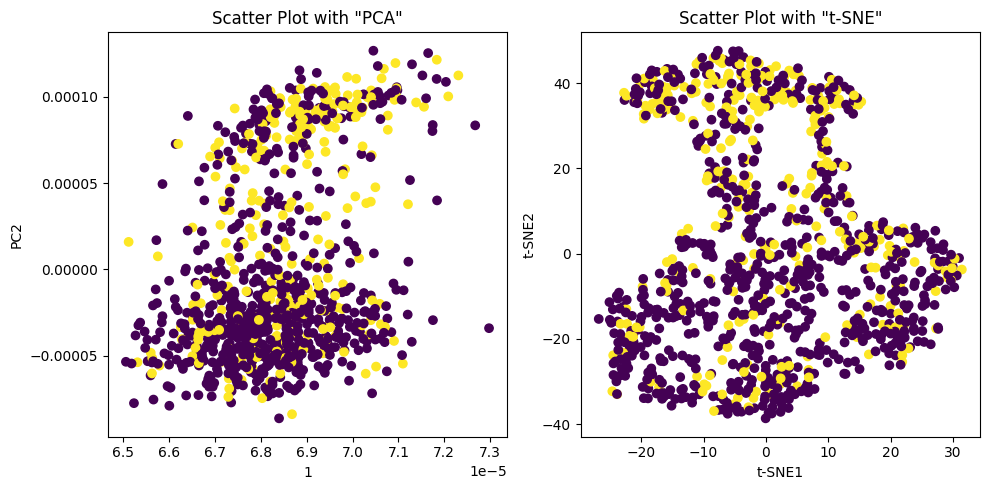

In [ ]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(low_test_feas)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(low_test_feas)

# Plotting the reduced data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=tr_label)
ax1.set_title('Scatter Plot with "PCA"')
ax1.set_xlabel('1')
ax1.set_ylabel('PC2')
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=tr_label)
ax2.set_title('Scatter Plot with "t-SNE"')
ax2.set_xlabel('t-SNE1')
ax2.set_ylabel('t-SNE2')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# feature knn

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
feas = enc

In [ ]:
# Create an instance of KMeans
kmeans = KMeans(n_clusters=5)
# Fit the model to your data
kmeans.fit(feas)

cluster_labels_kmeans = kmeans.labels_
label = labels['ans'][:1000].T[0]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(feas)

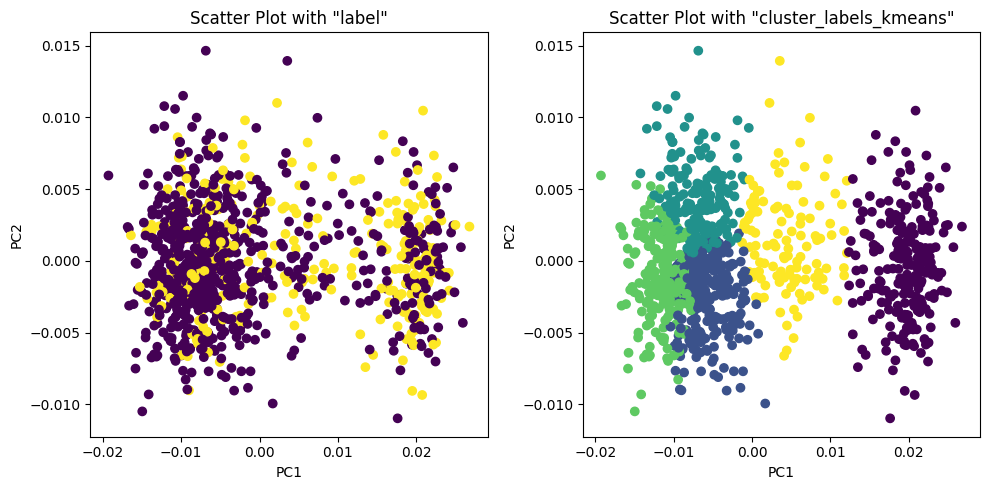

In [ ]:
# Plotting the reduced data

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(X[:, 0], X[:, 1], c=label)
ax1.set_title('Scatter Plot with "label"')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax2.scatter(X[:, 0], X[:, 1], c=cluster_labels_kmeans)
ax2.set_title('Scatter Plot with "cluster_labels_kmeans"')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

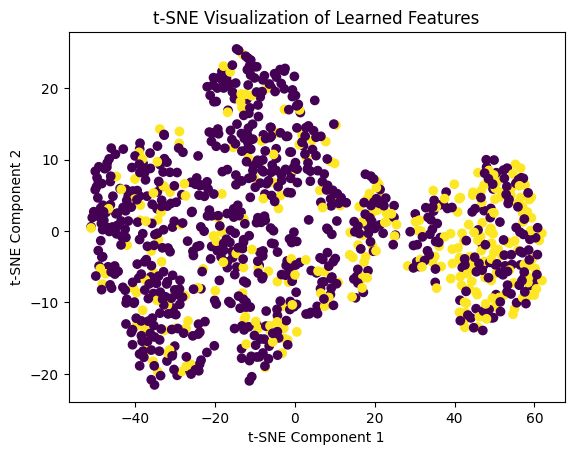

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(feas)

# Plot the t-SNE visualization
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=label)
plt.title('t-SNE Visualization of Learned Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()